# BDRW Project
## Gursharan Ahir
## 16EC10021

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# The dataset directory
curr_dir= "/content/drive/My Drive/Datasetsnew/BDRW_train"

In [0]:
#Data Loader utility for the BDRW Dataset with custom transform

class BengaliDataset():
    def __init__(self, dataset, currdir, transform=None):
        """
        Args:
            csv_file (string): Path to annotated csv file.
            currdir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labelsf = dataset
        self.currdir = currdir
        self.transform = transform

    def __len__(self):
        return len(self.labelsf)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img is the full path to image
        img = os.path.join(self.currdir,self.labelsf.iloc[idx, 0])
        img = img + ".jpg"
        image = Image.open(img)

        #label of corresponding image
        label = self.labelsf.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        return image, label

In [0]:
# Reading the label excel sheet for dataset splitting

labelsf = pd.read_excel(curr_dir + "/labels.xls", index_col=None, header=None)
# Random Split the dataset into train, test, validation
# 70% of the total to train
# 20% of the total to validation
# 10% of the total to test
train, val, test = np.split(labelsf.sample(frac=1), [int(0.7*len(labelsf)), int(0.9*len(labelsf))])

In [0]:
# Defining the dataloaders

Batch_Size = 16

# Image is resized to square image with grayscale transform
apply_transform = transforms.Compose([transforms.Resize((32,32)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# Random shuffle given to each data sampler with above transform
train_dataset = BengaliDataset( dataset = train, currdir= curr_dir + "/", transform=apply_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, num_workers=4)

val_dataset = BengaliDataset( dataset = val, currdir= curr_dir + "/",transform=apply_transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=Batch_Size, shuffle=True, num_workers=4)

test_dataset = BengaliDataset( dataset = test, currdir= curr_dir + "/",transform=apply_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True, num_workers=4)


In [0]:
# LeNet Model Architecture for classification

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.Conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.Pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.Pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.FC1 = nn.Linear(400, 120)
        self.FC2 = nn.Linear(120, 84)
        self.FC3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = self.Pool1(x)
        x = F.relu(self.Conv2(x))
        x = self.Pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.FC1(x)) 
        x = F.relu(self.FC2(x))
        x = self.FC3(x)
        return F.log_softmax(x,dim=1)

In [8]:
# Model instantiated and cuda incorporated

use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    net = net.cuda()

LeNet(
  (Conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC1): Linear(in_features=400, out_features=120, bias=True)
  (FC2): Linear(in_features=120, out_features=84, bias=True)
  (FC3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# CE Loss object
criterion = nn.CrossEntropyLoss()

# HyperParameters

# Learning rate is taken to be constant for training
learning_rate = 0.001

# Similar to 90% train accuracy is obtained at 50 epochs, model trained for 70 epochs since the loss stagnates nearly
num_epochs = 70

# Optimizer: Stochastic Gradient descent 
optimizer = optim.SGD(net.parameters(),lr=learning_rate, momentum = 0.9)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(num_epochs):
    
    # Training Phase
    running_loss = 0.0 
    running_corr = 0
        
    for i,data in enumerate(trainloader):
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 

        # Set model gradients zero
        net.zero_grad() 

        # Set the paramenter gradients to zero
        optimizer.zero_grad()

        # Feed-forward the data
        outputs = net(inputs)

        # Maximum probability class is the predicted class
        preds = torch.argmax(outputs,dim=1)

        # Cross Entropy Loss calculated
        loss = criterion(outputs, labels)

        # Accumulating the Batch loss
        running_loss += loss 

        # Accumulating th correct predictions measure
        running_corr += torch.sum(preds==labels)    

        # Calculating gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()
        

    # Validation Phase
    i=0
    correct_pred1 = 0
    running_loss1 = 0.0
  
    for data in valloader:
        inputs1,labels1 = data

        if use_gpu:
            inputs1, labels1 = inputs1.cuda(),labels1.cuda()

        # Feed-forward the data
        outputs1 = net(inputs1) 

        # Maximum probability class is the predicted class
        preds1 = torch.argmax(outputs1,dim=1)

        # Cross Entropy Loss calculated
        loss1 = criterion(outputs1, labels1)

        # Accumulating the Batch loss
        running_loss1 += loss1

        # Accumulating th correct predictions measure
        correct_pred1 += torch.sum(preds1==labels1)
        i += 1

    # Training loss for each epoch
    epoch_loss = running_loss.item()/(1.0*(i+1))   
    # Training Accuracy for each epoch
    epoch_acc = running_corr.item()/(1.0*len(train_dataset))

    # Validation loss for each epoch
    epochval_loss = running_loss1.item()/(1.0*(i+1))
    # Validation Accuracy for each epoch    
    epochval_acc = correct_pred1.item()/(1.0*len(val_dataset))

    val_loss.append(epochval_loss) #Saving the loss over epochs for plotting the graph
    val_acc.append(epochval_acc) #Saving the accuracy over epochs for plotting the graph
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}| Validation Loss: {:.4f}| Validation Accuracy: {:.4f}'.format(epoch+1, num_epochs,epoch_loss, epoch_acc*100.0, epochval_loss, epochval_acc*100.0 ))

Epoch 1/70 : Training loss: 7.3650 | Training Accuracy: 16.1026| Validation Loss: 2.1643| Validation Accuracy: 20.1439
Epoch 2/70 : Training loss: 7.3140 | Training Accuracy: 20.1026| Validation Loss: 2.1520| Validation Accuracy: 20.1439
Epoch 3/70 : Training loss: 7.2635 | Training Accuracy: 20.1026| Validation Loss: 2.1335| Validation Accuracy: 20.1439
Epoch 4/70 : Training loss: 7.2068 | Training Accuracy: 20.1026| Validation Loss: 2.1170| Validation Accuracy: 20.1439
Epoch 5/70 : Training loss: 7.1478 | Training Accuracy: 20.1026| Validation Loss: 2.1021| Validation Accuracy: 20.1439
Epoch 6/70 : Training loss: 7.1152 | Training Accuracy: 20.1026| Validation Loss: 2.0980| Validation Accuracy: 20.1439
Epoch 7/70 : Training loss: 7.1026 | Training Accuracy: 20.1026| Validation Loss: 2.0884| Validation Accuracy: 20.1439
Epoch 8/70 : Training loss: 7.0932 | Training Accuracy: 20.1026| Validation Loss: 2.0814| Validation Accuracy: 20.1439
Epoch 9/70 : Training loss: 7.0885 | Training Ac

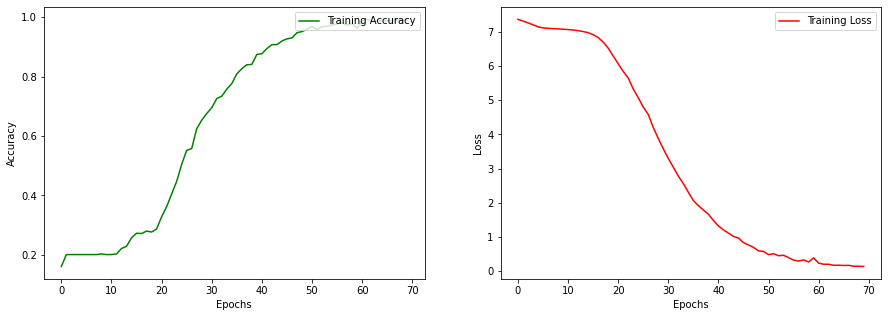

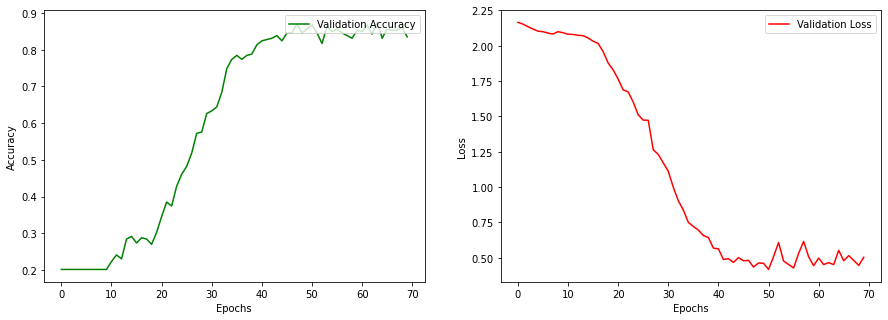

In [10]:
# Plots for training and validation
fig = plt.figure(figsize=[15,5]) 


plt.subplot(121)
plt.plot(range(num_epochs),train_acc,'g-',label='Training Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(range(num_epochs),train_loss,'r-',label='Training Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

fig = plt.figure(figsize=[15,5]) 

plt.subplot(121)
plt.plot(range(num_epochs),val_acc,'g-',label='Validation Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(range(num_epochs),val_loss,'r-',label='Validation Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [11]:
corr_pred = 0
for data in testloader:
    images,labels = data
    if use_gpu:
        images, labels = images.cuda(),labels.cuda()
    # Feedforward train data 
    output = net(images) 
    
    # Maximum probability class is the predicted class
    preds = torch.argmax(output,dim=1)
    corr_pred += torch.sum(preds==labels)

test_accuracy = corr_pred.item()/len(test_dataset)
print('Testing accuracy: ',round(test_accuracy*100.0,4))

Testing accuracy:  93.5714


In [12]:
# Model Space
# Print model's state_dict

total_params=0
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    size=net.state_dict()[param_tensor].shape
    pars=1
    for i in range(len(size)):
      pars*=size[i]
    total_params+=pars

print("Total Model Parameters:",total_params)


Model's state_dict:
Conv1.weight 	 torch.Size([6, 1, 5, 5])
Conv1.bias 	 torch.Size([6])
Conv2.weight 	 torch.Size([16, 6, 5, 5])
Conv2.bias 	 torch.Size([16])
FC1.weight 	 torch.Size([120, 400])
FC1.bias 	 torch.Size([120])
FC2.weight 	 torch.Size([84, 120])
FC2.bias 	 torch.Size([84])
FC3.weight 	 torch.Size([10, 84])
FC3.bias 	 torch.Size([10])
Total Model Parameters: 61706
